In [15]:
import numpy as np
import scipy.io as sp
import pandas as pd 
from scipy.stats import beta,linregress,bernoulli
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
class BetaModel():
    def __init__(self,leak_factor=1):             
                
        self.a = 1  # the number of times this action returned a win       
        self.b = 1  # the number of times this action returned a loss
        self.n=0
        self.omega=leak_factor
        # pass the true probablity of the outcome|action taken              
    
    def outcome(self,q):        
        #return the outcome with the predifined Contengency
        return np.random.random() < q
                    
    def update(self,reward):
        """ increase the number of times the scenario (i.e player has been chosen to play or not play)
            update the counts of the number of times game has been won or lost given the action 
        """
        self.n += 1    
        if reward==1:
            
            self.a += 1
        else:
            self.b += 1
        
        self.a*=self.omega
        self.b*=self.omega
        
    def reset(self):
        self.n=0
        self.a=1
        self.b=1

    def sample(self):
         #return a value sampled from the beta distribution 
        return np.random.beta(self.a,self.b)
        #return np.mean(np.random.beta(self.a,self.b,10))
    
    def buy(self):
        return int(beta.mean(self.a,self.b)>0.5)
        
    
    def buy_confidence(self):
        if self.buy()==1:
        #return np.abs(beta.mean(self.a,self.b)-0.5)
            return beta.sf(.5,self.a,self.b)
        else:
            return beta.cdf(.5,self.a,self.b)

In [17]:
def plot_distributions(betamodels, emp_cond_probas,actions ):
    x = np.linspace(0.0,1.0,200)
    trials = sum([betamodel.n for betamodel in betamodels])
    
    colors = ["green","red","blue"]
    
    c_index = 0    
    
    for i in range(len(emp_cond_probas)):
        
        c = colors[c_index]
        
        y = beta(betamodels[i].a,betamodels[i].b)
        p = plt.plot(x, y.pdf(x), lw=2, color=c, label =f"{actions[i]} = {betamodels[i].a-1}/{betamodels[i].n}")
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=0.2 )
        plt.vlines(emp_cond_probas[i], 0, y.pdf(emp_cond_probas[i]), colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title(f"{trials} Trials")
        plt.legend()
        plt.autoscale(tight=True)
        c_index += 1

'/Users/hamzahalloway/Desktop/Internship M2/causal/Causal_Hamza'

## Empowerment

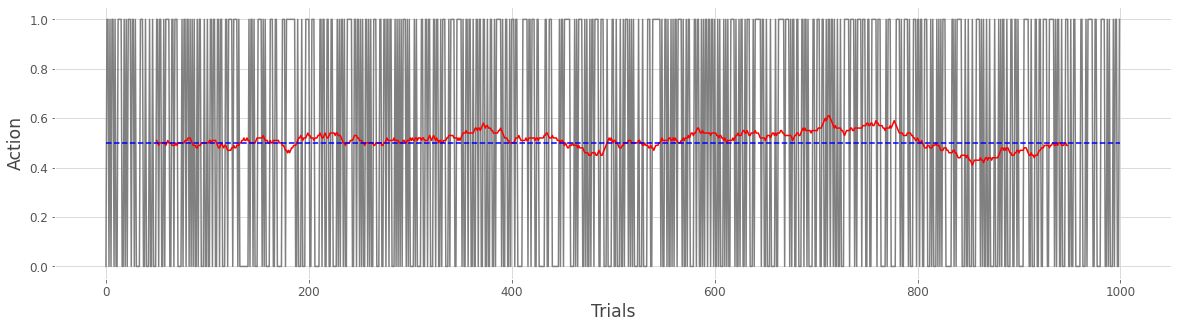

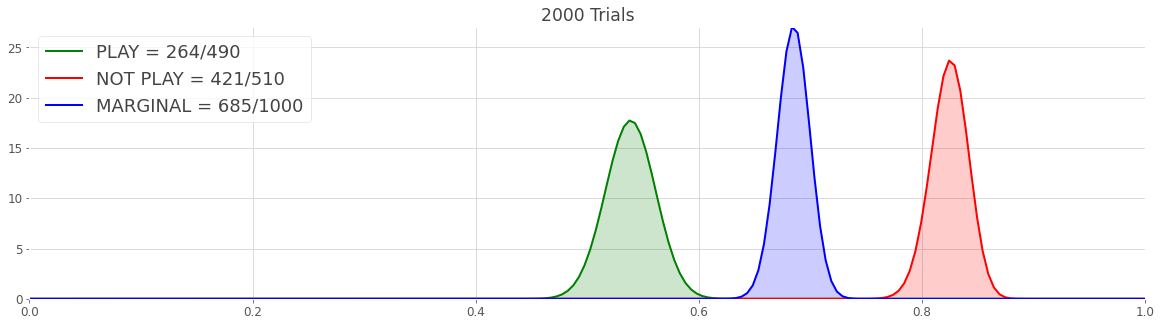

In [69]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2]]
actions=[]

mr1, mr2, mq1, mq2, mq3 = [], [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()

    
    r1 = (1-q1) * (np.log(1-q1) - np.log(1-q3)) + q1 *  (np.log(q1) - np.log(q3))
    r2 = (1-q2) * (np.log(1-q2) - np.log(1-q3)) + q2 *  (np.log(q2) - np.log(q3))
    
    
    mq1 += [q1]
    mq2 += [q2]
    mq3 += [q3]
    mr1 += [r1]
    mr2 += [r2]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    
    beta_model[2].update(outcome)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions,c="gray")       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='blue')
plt.ylabel("Action")
plt.xlabel("Trials")
plt.savefig('/Users/hamzahalloway/Desktop/Internship M2/causal/Causal_Hamza/plots/ideal_participant')
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])
plt.savefig('/Users/hamzahalloway/Desktop/Internship M2/causal/Causal_Hamza/plots/KL_distri')


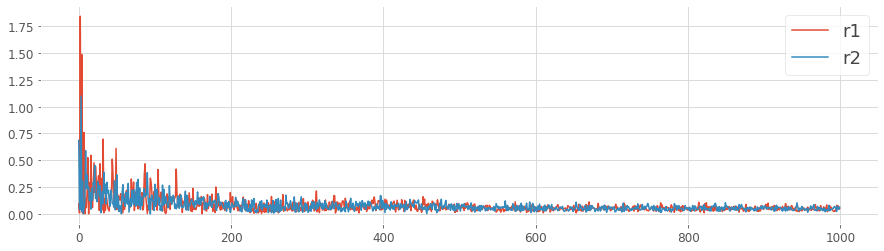

In [56]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

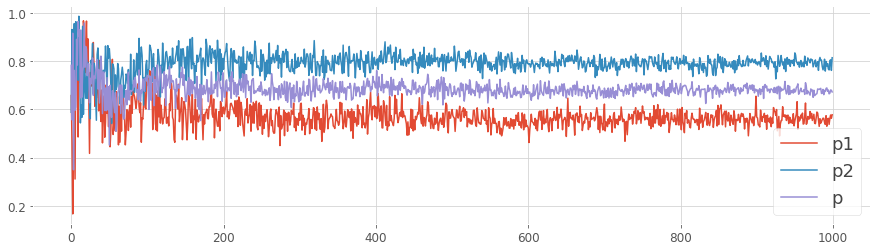

In [20]:
plt.figure(figsize=(15,4))
plt.plot(mq1, label='p1')
plt.plot(mq2, label='p2')
plt.plot(mq3, label='p')
plt.grid('on')
plt.legend()

## Reverse Empowerment

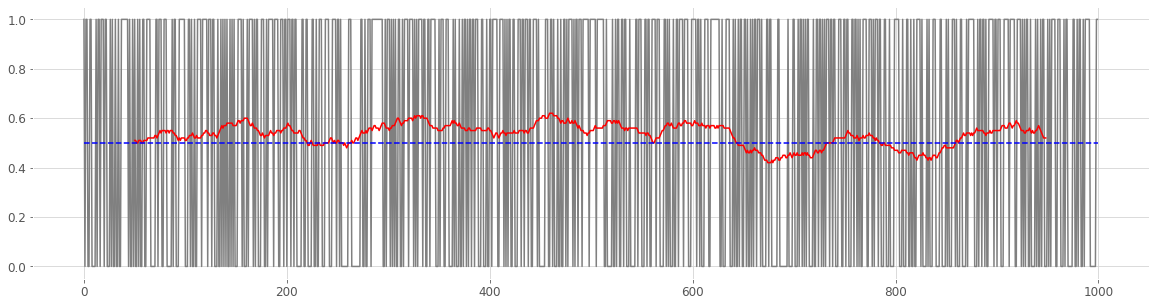

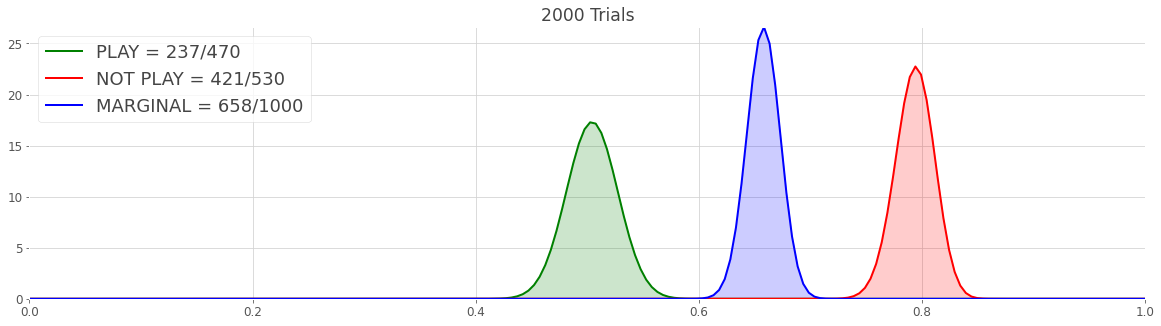

In [52]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2]]
actions=[]

mr1, mr2, mq1, mq2, mq3 = [], [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()

    
    r1 = (1-q3) * (-np.log(1-q1) + np.log(1-q3)) + q3 *  (-np.log(q1) + np.log(q3))
    r2 = (1-q3) * (-np.log(1-q2) + np.log(1-q3)) + q3 *  (-np.log(q2) + np.log(q3))
    
    
    mq1 += [q1]
    mq2 += [q2]
    mq3 += [q3]
    mr1 += [r1]
    mr2 += [r2]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions,c="grey")       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='blue')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


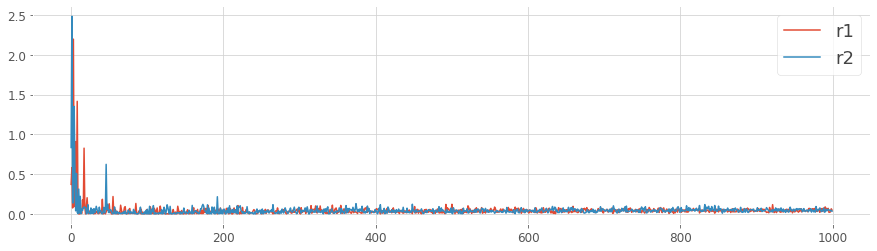

In [22]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

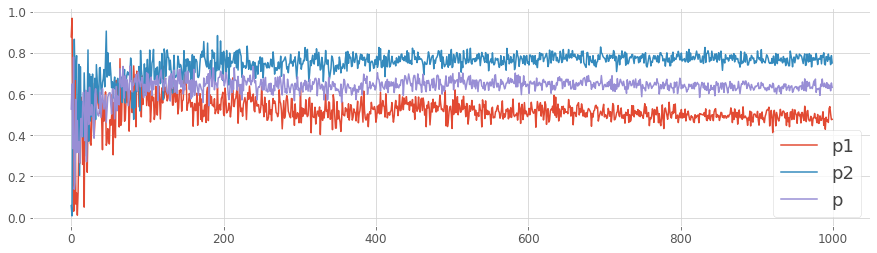

In [23]:
plt.figure(figsize=(15,4))
plt.plot(mq1, label='p1')
plt.plot(mq2, label='p2')
plt.plot(mq3, label='p')
plt.grid('on')
plt.legend()

## Final Empowerment

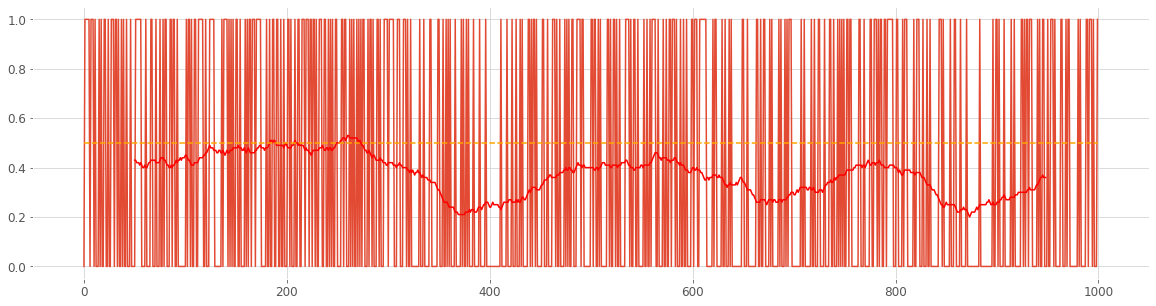

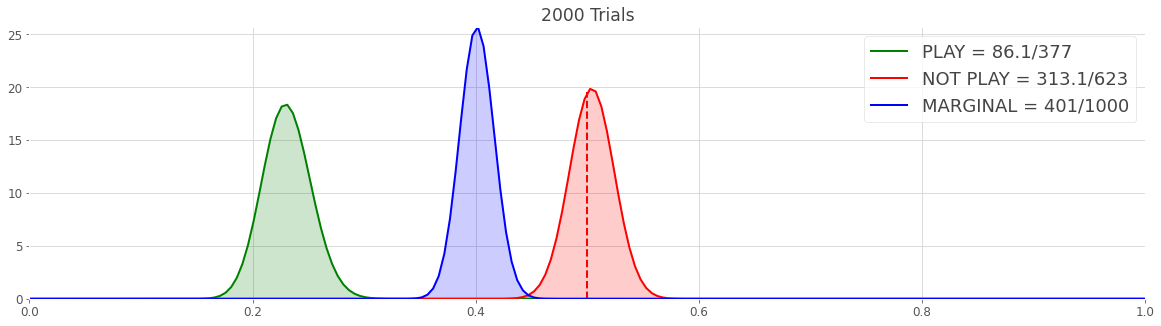

In [24]:
p = [0.5, .2] # p(WIN|NOT PLAY) p(WIN|PLAY); 
beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

beta_model[0].a = .1
beta_model[0].b = .1
beta_model[1].a = .1
beta_model[1].b = .1


mr1, mr2, mq1, mq2, mq3 = [], [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    pi=beta_model[3].sample()

    EMP_WIN =   (1-pi) * ( -np.log(q1) + np.log(q3))    + pi * ( -np.log(q2) + np.log(q3))
    EMP_LOOSE = (1-pi) * (-np.log(1-q1) + np.log(1-q3)) + pi * (-np.log(1-q2) + np.log(1-q3))
        
    #r1 = (1-q3) * (-np.log(1-q1) + np.log(1-q3)) + q3 *  (-np.log(q1) + np.log(q3))
    #r2 = (1-q3) * (-np.log(1-q2) + np.log(1-q3)) + q3 *  (-np.log(q2) + np.log(q3))

    r1 = q1 * EMP_WIN + (1 - q1) * EMP_LOOSE #- (1-q1) * np.log(1-q3) - q1 * np.log(q3)
    r2 = q2 * EMP_WIN + (1 - q2) * EMP_LOOSE #- (1-q2) * np.log(1-q3) - q2 * np.log(q3) 
    
    mq1 += [q1]
    mq2 += [q2]
    mq3 += [q3]
    mr1 += [r1]
    mr2 += [r2]
    
    if r1 > r2:
        a = 0 # not play
    else:
        a = 1 # play
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[1], beta_model[0], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


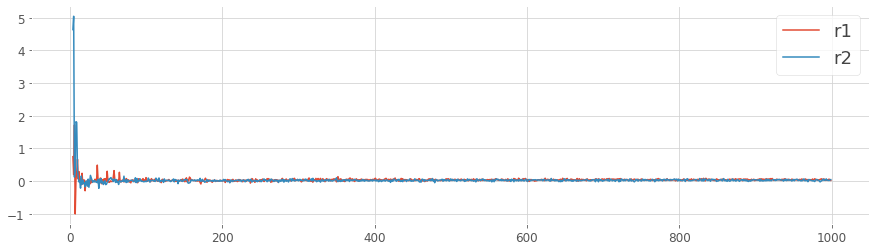

In [25]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

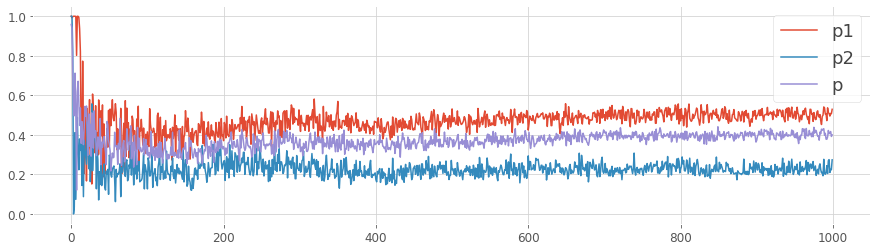

In [26]:
plt.figure(figsize=(15,4))
plt.plot(mq1, label='p1')
plt.plot(mq2, label='p2')
plt.plot(mq3, label='p')
plt.grid('on')
plt.legend()

## Full Saliency

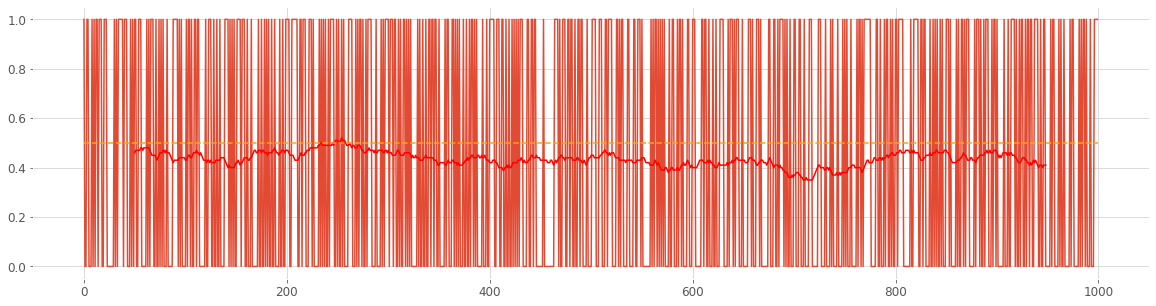

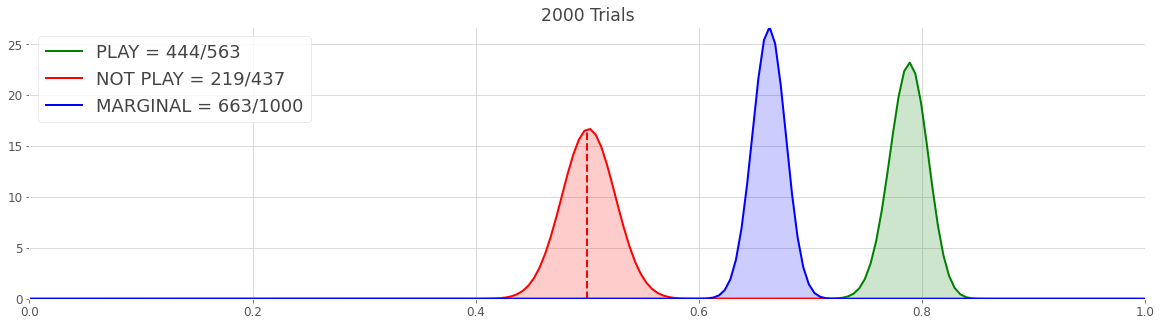

In [27]:
p = [0.8, .5] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

mr1, mr2, mr1b, mr2b = [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    
    pi = beta_model[3].sample()

    #mu_1 = beta.mean(beta_model[0].a, beta_model[0].b)
    #mu_2 = beta.mean(beta_model[1].a, beta_model[1].b)
    #mu_3 = beta.mean(beta_model[2].a, beta_model[2].b)
    #r1_barre = (1-mu_1) * (0 + np.log(1-mu_1) - np.log(1-mu_3)) + mu_1 *  (1 + np.log(mu_1) - np.log(mu_3))
    #r2_barre = (1-mu_2) * (0 + np.log(1-mu_2) - np.log(1-mu_3)) + mu_2 *  (1 + np.log(mu_2) - np.log(mu_3))
    
    
    REW = 1
    b = 1
    
    r1 = (1-q1) * (-b * REW*0 + np.log(1-q1) - np.log(1-q3)) + q1 *  (b * REW + np.log(q1) - np.log(q3)) - np.log(1-pi)
    r2 = (1-q2) * (-b * REW*0 + np.log(1-q2) - np.log(1-q3)) + q2 *  (b * REW + np.log(q2) - np.log(q3)) - np.log(pi)
    
    mr1 += [r1]
    mr2 += [r2]
    #mr1b += [r1_barre]
    #mr2b += [r2_barre]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


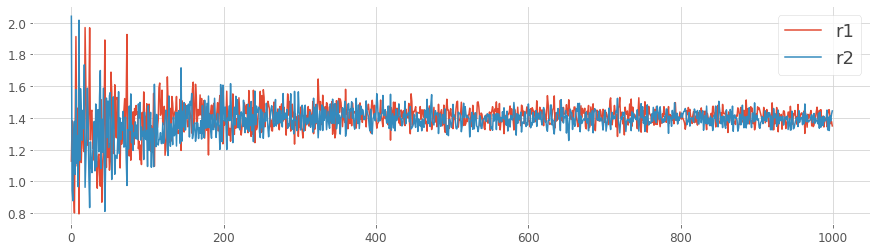

In [28]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

In [29]:
mu_1 = beta.mean(beta_model[0].a, beta_model[0].b)
mu_2 = beta.mean(beta_model[1].a, beta_model[1].b) 
mu_pi = beta.mean(beta_model[3].a, beta_model[3].b) 

DP = (1-mu_1) * (-REW*0) + mu_1 * (REW) - (1-mu_2) * (-REW*0) - mu_2 *  (REW)
    
pi, np.log(1-mu_pi) - np.log(mu_pi), DP

(0.4152073761864644, 0.25283534112161277, 0.2864716673050174)

## SAC / policy matching

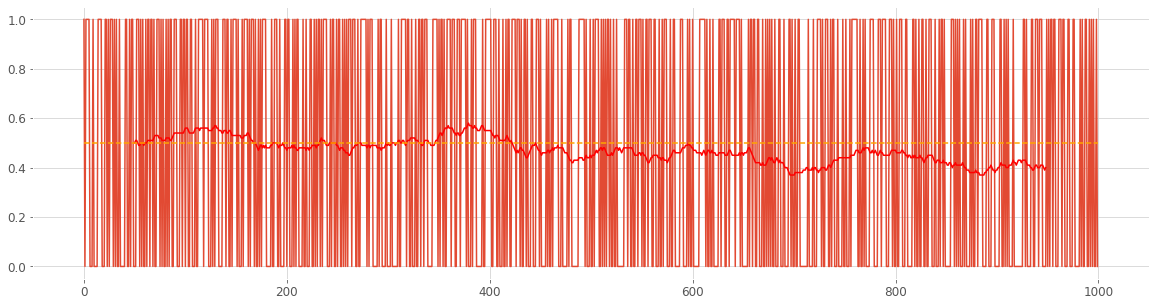

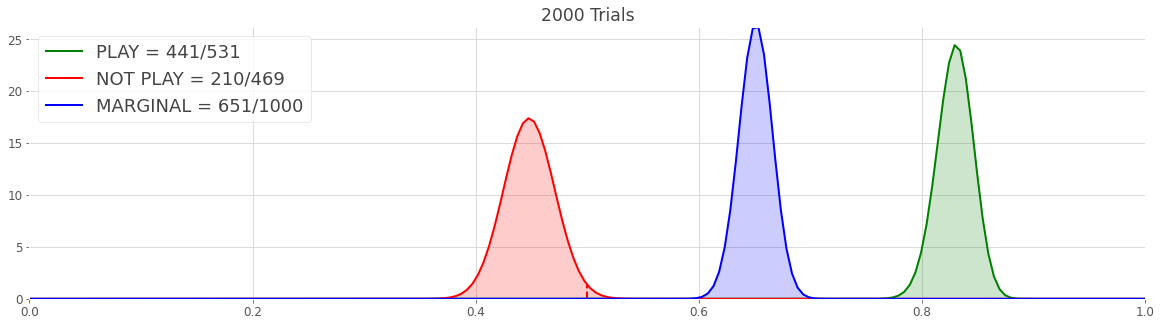

In [30]:
p = [0.8, .5] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

mr1, mr2, mr1b, mr2b = [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    
    pi = beta_model[3].sample() 
    
    lamb=1
    REW = 1 * lamb
    
    r1 = (1-q1) * (-REW) + q1 *  (REW) - np.log(1-pi) + np.log(0.35)
    r2 = (1-q2) * (-REW) + q2 *  (REW) - np.log(pi) + np.log(0.65)
    
    mr1 += [r1]
    mr2 += [r2]
    #mr1b += [r1_barre]
    #mr2b += [r2_barre]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


In [31]:
mu_1 = beta.mean(beta_model[0].a, beta_model[0].b)
mu_2 = beta.mean(beta_model[1].a, beta_model[1].b) 
mu_pi = beta.mean(beta_model[3].a, beta_model[3].b) 

DP = (1-mu_1) * (-REW*0) + mu_1 * (REW) - (1-mu_2) * (-REW*0) - mu_2 *  (REW)

    
pi, np.log(1-mu_pi) - np.log(mu_pi), DP

(0.49816542658227764, 0.12391079463754018, 0.381285277820931)

## Marginal surprise = Pure Information bias

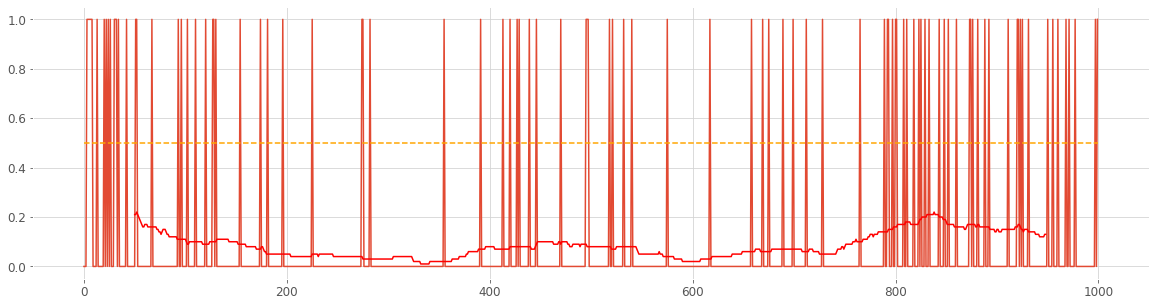

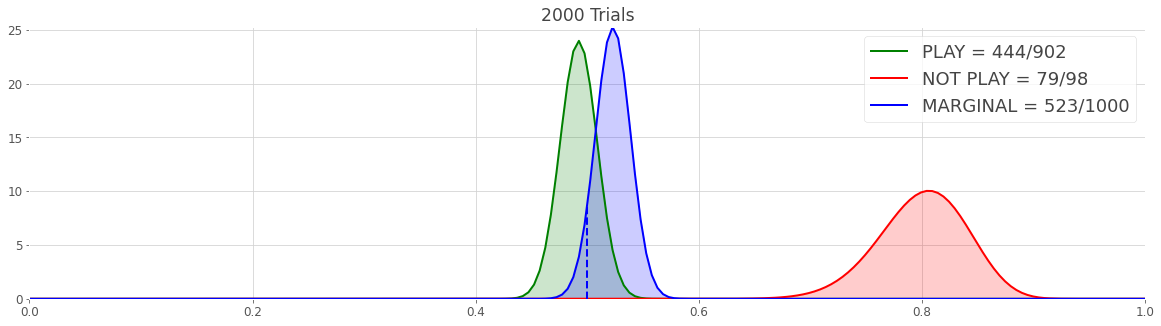

In [32]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2]]
actions=[]
for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()

    
    r1 = (1-q1) * ( - np.log(1-q3)) + q1 *  ( - np.log(q3))
    r2 = (1-q2) * ( - np.log(1-q3)) + q2 *  ( - np.log(q3))
    
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])



## Marginal surprise with policy matching

--> information bias

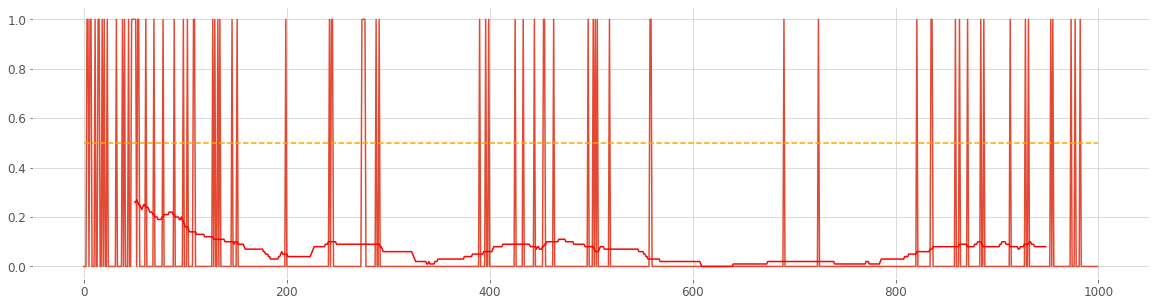

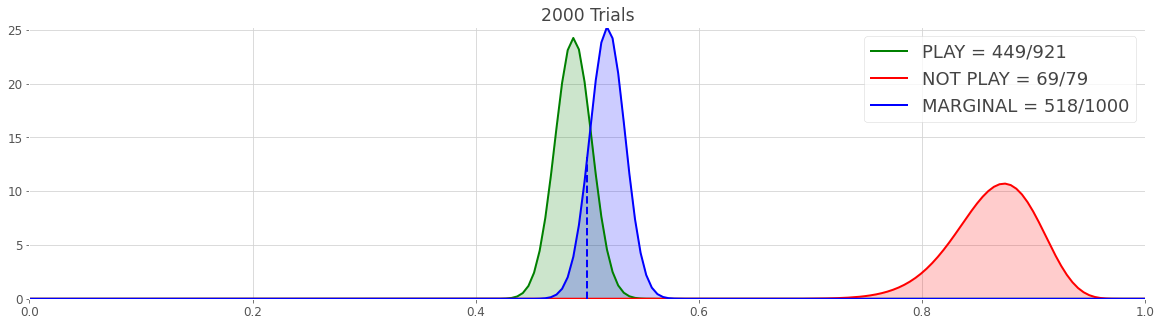

In [33]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

mr1, mr2, mr1b, mr2b = [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    
    pi = beta_model[3].sample() 
    
    b = 1000
        
    r1 = b * ((1-q1) * (- np.log(1-q3)) + q1 *  (-np.log(q3))) - np.log(1-pi)
    r2 = b * ((1-q2) * (- np.log(1-q3)) + q2 *  (-np.log(q3))) - np.log(pi)
    
    mr1 += [r1]
    mr2 += [r2]
    #mr1b += [r1_barre]
    #mr2b += [r2_barre]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


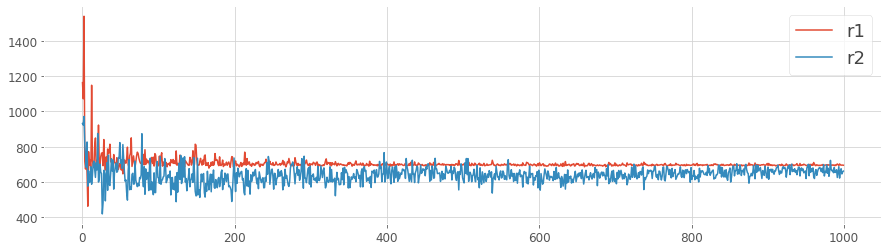

In [34]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

## MIG

--> reward bias

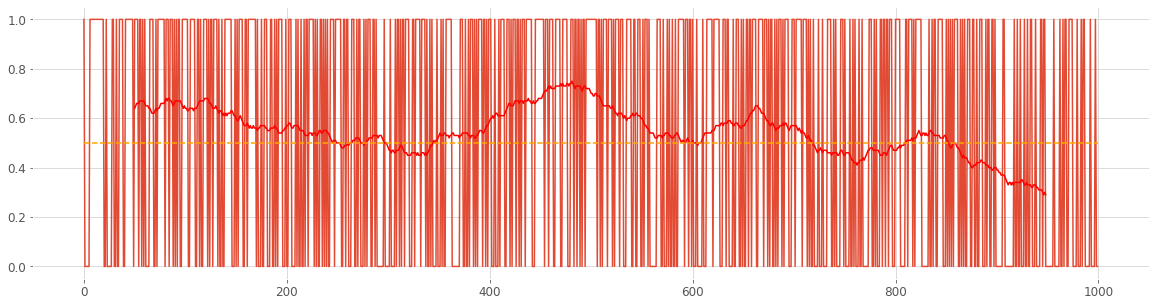

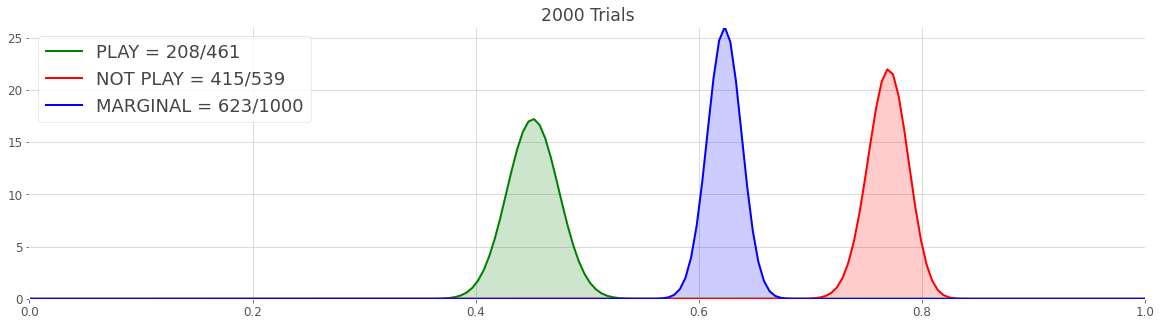

In [35]:
#p = [0.2, .5] # p(WIN|PLAY); p(WIN|NOT PLAY)
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)

beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

mr1, mr2, mr1b, mr2b = [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    
    pi = beta_model[3].sample() 
    
    REW = 1
    lamb = .5
    
    r1 = (1-q1) * (- np.log(1-q3)) + q1 *  (lamb * REW -np.log(q3)) #- np.log(1-pi)
    r2 = (1-q2) * (- np.log(1-q3)) + q2 *  (lamb * REW -np.log(q3)) #- np.log(pi)
    
    mr1 += [r1]
    mr2 += [r2]
    #mr1b += [r1_barre]
    #mr2b += [r2_barre]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


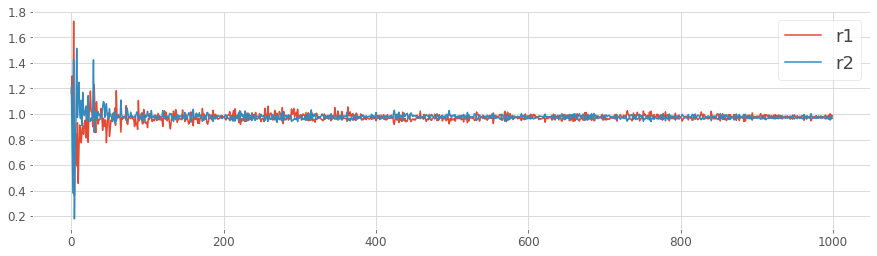

In [36]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

In [37]:
mu_1 = beta.mean(beta_model[0].a, beta_model[0].b)
mu_2 = beta.mean(beta_model[1].a, beta_model[1].b) 
mu_pi = beta.mean(beta_model[3].a, beta_model[3].b) 

DP = (1-mu_1) * (-REW*0) + mu_1 * (REW) - (1-mu_2) * (-REW*0) - mu_2 *  (REW)
    
pi, np.log(1-mu_pi) - np.log(mu_pi), DP

(0.5222341852591631, -0.15600424847658134, -0.3175425078747859)

In [38]:
mu_3 = beta.mean(beta_model[2].a, beta_model[2].b) 
    
REW, np.log(mu_3) - np.log(1-mu_3)

(1, 0.5012561727498401)

## CCA

idée : CCA = naive bayes. simplification de la formule IG du départ? Valide pour sampling uniforme?

--> double biais

L'ajout du terme de matching correspond à un comportemet d'exploration??

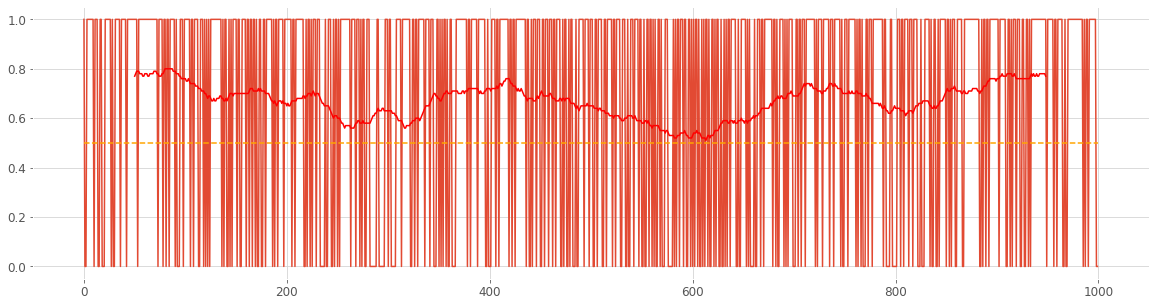

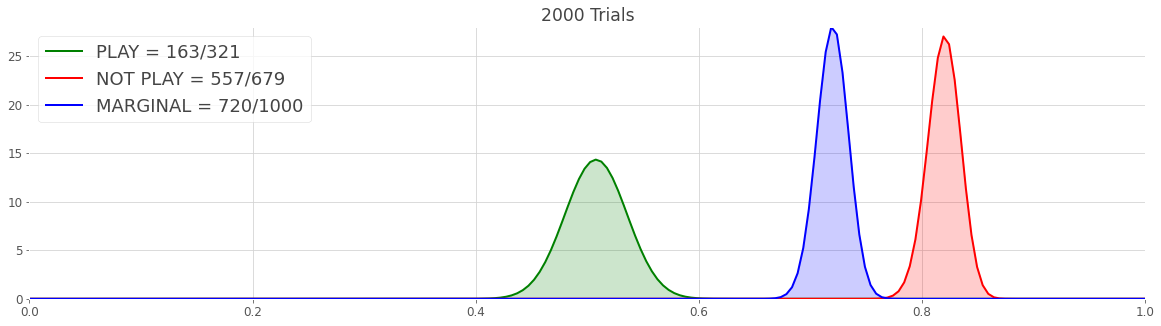

In [39]:
p = [0.2, .5] # p(WIN|PLAY); p(WIN|NOT PLAY)
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)

beta_model = [BetaModel() for a in [0, 1, 2, 3]]
actions=[]

mr1, mr2, mr1b, mr2b = [], [], [], []

for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()
    
    pi = beta_model[3].sample() 
    
    REW = 1
    b = 1000
    lamb = 1
    
    r1 = b*((1-q1) * (- np.log(1-q3)) + q1 * (lamb * REW - np.log(q3))) - np.log(1-pi)
    r2 = b*((1-q2) * (- np.log(1-q3)) + q2 * (lamb * REW - np.log(q3))) - np.log(pi)
    
    mr1 += [r1]
    mr2 += [r2]
    #mr1b += [r1_barre]
    #mr2b += [r2_barre]
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    beta_model[3].update(a)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])


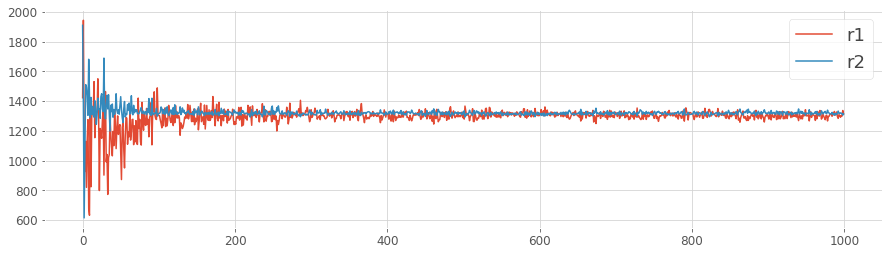

In [40]:
plt.figure(figsize=(15,4))
plt.plot(mr1, label='r1')
plt.plot(mr2, label='r2')
plt.grid('on')
plt.legend()

In [41]:
mu_1 = beta.mean(beta_model[0].a, beta_model[0].b)
mu_2 = beta.mean(beta_model[1].a, beta_model[1].b) 
mu_pi = beta.mean(beta_model[3].a, beta_model[3].b) 

DP = (1-mu_1) * (-REW*0) + mu_1 * (REW) - (1-mu_2) * (-REW*0) - mu_2 *  (REW)
    
pi, np.log(1-mu_pi) - np.log(mu_pi), DP

(0.6927917780625269, -0.7475412526257439, -0.311643321831399)

In [42]:
mu_3 = beta.mean(beta_model[2].a, beta_model[2].b) 
    
REW, np.log(mu_3) - np.log(1-mu_3)

(1, 0.9422844679512036)

## Test (??)

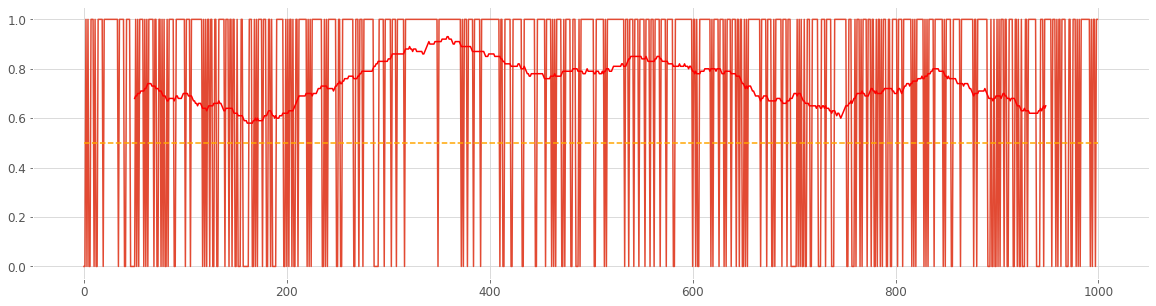

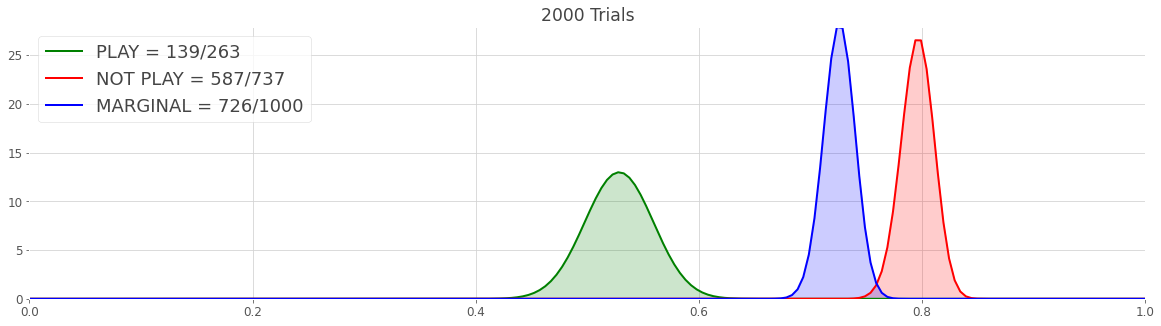

In [43]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2]]
actions=[]
for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()

    
    r1 = (1-q1) * ( - np.log(1-q3)) + q1 *  ( - np.log(q3)) + q1
    r2 = (1-q2) * ( - np.log(1-q3)) + q2 *  ( - np.log(q3)) + q2
    
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])



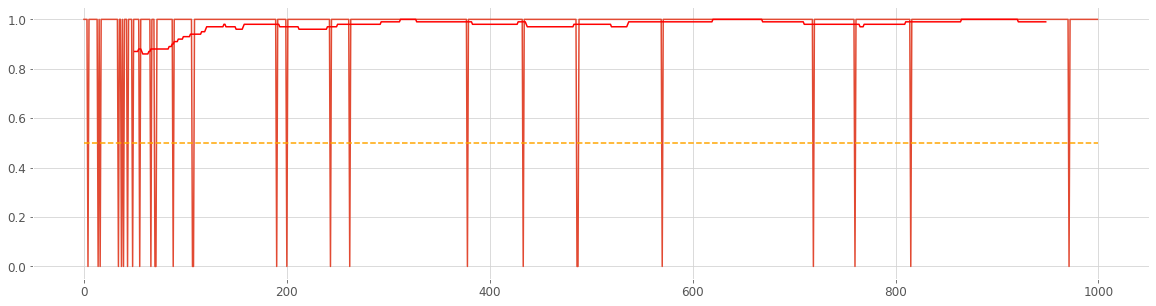

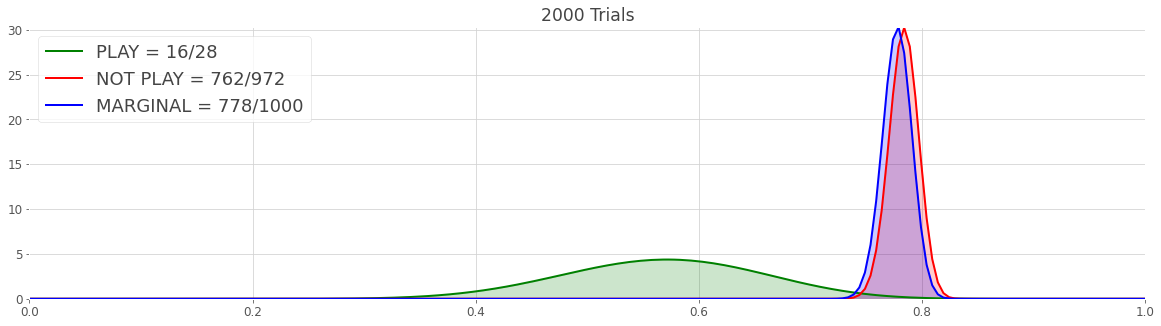

In [44]:
p = [0.5, .8] # p(WIN|PLAY); p(WIN|NOT PLAY)
beta_model = [BetaModel() for a in [0, 1, 2]]
actions=[]
for trial in range(1000):
    q1=beta_model[0].sample()
    q2=beta_model[1].sample()
    q3=beta_model[2].sample()

    
    r1 =  q1
    r2 =  q2
    
    
    if r1 > r2:
        a = 0
    else:
        a = 1
    actions.append(a)
        
    outcome = bernoulli.rvs(p[a])
    
    #print(r1, r2, "choix = ", a, "outcome=", outcome)
    
    beta_model[a].update(outcome)
    beta_model[2].update(outcome)
    
    #plt.figure()
    #plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

plt.figure(figsize=(20,5))
plt.plot(actions)       
plt.plot(range(50,949),np.convolve(actions, np.ones(100)/100)[100:-100],'r')
plt.plot([0, 1000], [0.5, 0.5], '--', c='orange')
    
plt.figure(figsize=(20,5))
plot_distributions([beta_model[0], beta_model[1], beta_model[2]], [1, 0.5, 0.5], ["PLAY", "NOT PLAY", "MARGINAL"])

